In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Sequential, optimizers

import os
import random 

%matplotlib inline

In [2]:
# settings for reproducibility
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

<h2>Experiment 1: run model without fully-connected layers</h2>

<h3>1. Initialize the model</h3>

Initialize the VGG16 model, setting ``include_top`` parameter to ``False`` in order to exclude the fully-connected layers at the top of the network.

In [3]:
vgg_conv = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [4]:
# VGG16 layer by layer
vgg_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

<h3>2. Prepare the training data</h3>

Define locations of the train and validation datasets:

In [5]:
# each folder contains three subfolders in accordance with the number of classes
train_dir = './clean-dataset/train'
validation_dir = './clean-dataset/validation'

# the number of images for train and test is divided into 80:20 ratio
nTrain = 600
nVal = 150

In [6]:
# load the normalized images
datagen = ImageDataGenerator(rescale=1./255)

# define the batch size
batch_size = 20

# the defined shape is equal to the network output tensor shape
train_features = np.zeros(shape=(nTrain, 7, 7, 512))
train_labels = np.zeros(shape=(nTrain,3))

# generate batches of train images and labels
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

Found 600 images belonging to 3 classes.


<h3>3. Visualize the training dataset</h3>

The shape of train images: (224, 224, 3)


Text(0.5, 1.0, 'Class name: pumpkin')

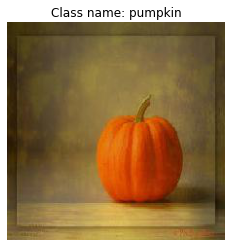

In [7]:
# choose the image index for the visualization
image_id = 0

# get the train image shape 
print("The shape of train images: {}".format(train_generator[image_id][0][0].shape))

# visualize the image example
plt.axis('off')
plt.imshow(train_generator[image_id][0][0])

# get image class and map its index with the names of the classes
train_image_label_id = np.argmax(train_generator[image_id][1][0])
classes_list = list(train_generator.class_indices.keys())

# show image class
plt.title("Class name: {}".format(classes_list[train_image_label_id]))

<h3>4. Obtain model predictions on the train data</h3>

Get the predictions passing the images from train dataset into the model:

In [8]:
# iterate through the batches of train images and labels
for i, (inputs_batch, labels_batch) in enumerate(train_generator):
    if i * batch_size >= nTrain:
        break    
    # pass the images through the network
    features_batch = vgg_conv.predict(inputs_batch)
    train_features[i * batch_size : (i + 1) * batch_size] = features_batch
    train_labels[i * batch_size : (i + 1) * batch_size] = labels_batch

# reshape train_features into vector        
train_features_vec = np.reshape(train_features, (nTrain, 7 * 7 * 512))
print("Train features: {}".format(train_features_vec.shape))

Train features: (600, 25088)


<h3>5. Prepare the validation data</h3>

In [9]:
validation_features = np.zeros(shape=(nVal, 7, 7, 512))
validation_labels = np.zeros(shape=(nVal,3))

# generate batches of validation images and labels
validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 150 images belonging to 3 classes.


<h3>6. Visualize the validation dataset</h3>

The shape of validation images: (224, 224, 3)


Text(0.5, 1.0, 'Class name: pumpkin')

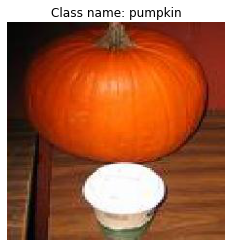

In [10]:
# choose the image index for the visualization
val_image_id = 0

# get the validation image shape 
print("The shape of validation images: {}".format(validation_generator[val_image_id][0][0].shape))

# visualize the image example
plt.axis('off')
plt.imshow(validation_generator[val_image_id][0][0])

# get image class and map its index with the names of the classes
val_image_label_id = np.argmax(validation_generator[val_image_id][1][0])
classes_list = list(validation_generator.class_indices.keys())

# show image class
plt.title("Class name: {}".format(classes_list[val_image_label_id]))

<h3>7. Obtain model predictions on the validation data</h3>

In [11]:
# iterate through the batches of validation images and labels
for i, (inputs_batch, labels_batch) in enumerate(validation_generator):
    if i * batch_size >= nVal:
        break
    features_batch = vgg_conv.predict(inputs_batch)
    validation_features[i * batch_size : (i + 1) * batch_size] = features_batch
    validation_labels[i * batch_size : (i + 1) * batch_size] = labels_batch

# reshape validation_features into vector 
validation_features_vec = np.reshape(validation_features, (nVal, 7 * 7 * 512))
print("Validation features: {}".format(validation_features_vec.shape))

Validation features: (150, 25088)


<h2>Experiment 2: Create your own model and train the network</h2>

<h3>1. Configure and train the model</h3>

In [12]:
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=7 * 7 * 512))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# configure the model for training
model.compile(optimizer=optimizers.RMSprop(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

# use the train and validation feature vectors 
history = model.fit(train_features_vec,
                    train_labels,
                    epochs=20,
                    batch_size=batch_size,
                    validation_data=(validation_features_vec,validation_labels))

Train on 600 samples, validate on 150 samples
Epoch 1/20
600/600 [==============================] - 0s 788us/sample - loss: 1.8973 - acc: 0.5200 - val_loss: 0.9535 - val_acc: 0.6067
Epoch 2/20
600/600 [==============================] - 0s 361us/sample - loss: 0.5096 - acc: 0.8133 - val_loss: 0.3948 - val_acc: 0.8400
Epoch 3/20
600/600 [==============================] - 0s 350us/sample - loss: 0.2985 - acc: 0.8850 - val_loss: 0.2773 - val_acc: 0.9067
Epoch 4/20
600/600 [==============================] - 0s 337us/sample - loss: 0.2093 - acc: 0.9250 - val_loss: 0.5048 - val_acc: 0.8200
Epoch 5/20
600/600 [==============================] - 0s 342us/sample - loss: 0.1285 - acc: 0.9533 - val_loss: 1.4573 - val_acc: 0.6067
Epoch 6/20
600/600 [==============================] - 0s 334us/sample - loss: 0.1112 - acc: 0.9550 - val_loss: 0.3297 - val_acc: 0.9133
Epoch 7/20
600/600 [==============================] - 0s 388us/sample - loss: 0.0513 - acc: 0.9833 - val_loss: 0.3409 - val_acc: 0.9067
Ep

<h3>2. Show the errors</h3>

In [13]:
# get the list of all validation file names
fnames = validation_generator.filenames

# get the list of the corresponding classes
ground_truth = validation_generator.classes

# get the dictionary of classes
label2index = validation_generator.class_indices

# obtain the list of classes
idx2label = list(label2index.keys())
print("The list of classes: ", idx2label)

The list of classes:  ['pumpkin', 'tomato', 'watermelon']


In [14]:
predictions = model.predict_classes(validation_features_vec)
prob = model.predict(validation_features_vec)

In [15]:
errors = np.where(predictions != ground_truth)[0]
print("Number of errors = {}/{}".format(len(errors),nVal))

Number of errors = 14/150


Original label:pumpkin, Prediction :tomato, confidence : 0.993


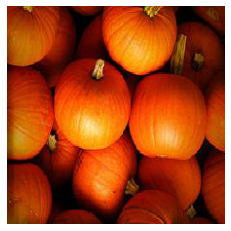

Original label:pumpkin, Prediction :tomato, confidence : 0.855


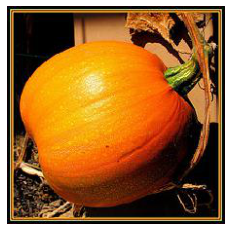

Original label:pumpkin, Prediction :tomato, confidence : 1.000


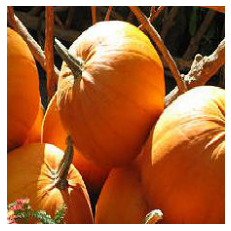

Original label:pumpkin, Prediction :watermelon, confidence : 0.998


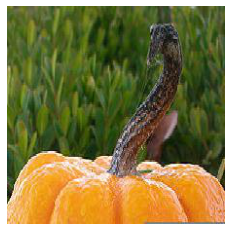

Original label:pumpkin, Prediction :tomato, confidence : 0.836


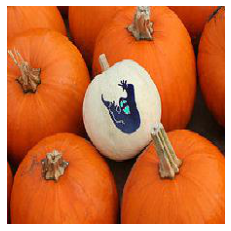

Original label:pumpkin, Prediction :tomato, confidence : 0.980


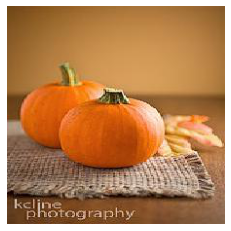

Original label:pumpkin, Prediction :tomato, confidence : 0.932


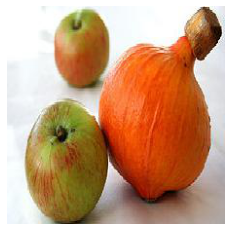

Original label:tomato, Prediction :pumpkin, confidence : 0.998


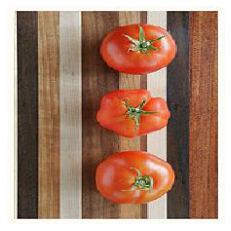

Original label:tomato, Prediction :pumpkin, confidence : 0.992


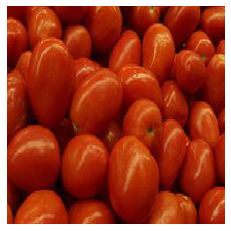

Original label:tomato, Prediction :watermelon, confidence : 1.000


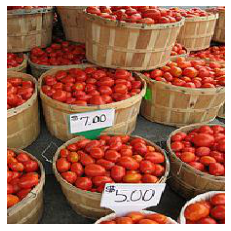

Original label:tomato, Prediction :pumpkin, confidence : 0.896


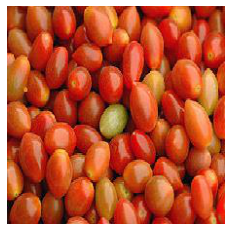

Original label:watermelon, Prediction :pumpkin, confidence : 0.988


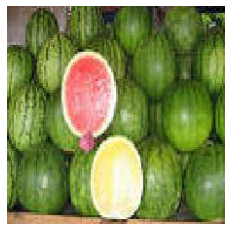

Original label:watermelon, Prediction :tomato, confidence : 0.732


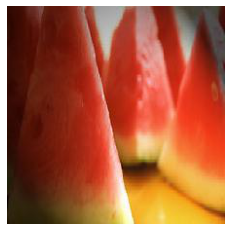

Original label:watermelon, Prediction :pumpkin, confidence : 0.993


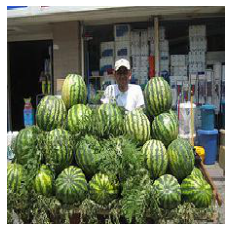

In [16]:
for i in range(len(errors)):
    pred_class = np.argmax(prob[errors[i]])
    pred_label = idx2label[pred_class]
    
    print('Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        prob[errors[i]][pred_class]))
    
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.axis('off')
    plt.imshow(original)
    plt.show()